In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os 
import copy
import glob
import cv2
import math
import tensorflow as tf
import tensorflow_hub as hub
import warnings
from keras import backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

## Data Preprocessing

In [3]:
train_path = r"/kaggle/input/nn23-sports-image-classification/Train"
test_path =r"/kaggle/input/nn23-sports-image-classification/Test"
# train_path = r"Train"
# test_path =r"Test"

In [4]:
train_imgs=os.listdir(train_path)
test_imgs=os.listdir(test_path)

In [5]:
code = {'Basketball' : 0 , 'Football' : 1 , 'Rowing' : 2 , 'Swimming' :3 ,"Tennis" : 4 , "Yoga" : 5}

def get_name(n):

    for x,y in code.items() :
        if y == n :
            return x

In [6]:
#get labels for training
train_labels = []

for cur_img in train_imgs:
    if "Basketball" in cur_img :
        label = (code["Basketball"])
    elif "Football" in cur_img :
        label = (code["Football"])
    elif "Rowing" in cur_img :
        label = (code["Rowing"])
    elif "Swimming" in cur_img :
        label = (code["Swimming"])
    elif "Tennis" in cur_img :
        label = (code["Tennis"])
    elif "Yoga" in cur_img :
        label = (code["Yoga"])

    train_labels.append(label)

In [7]:
#reading images 
def reading_resize(train_imgs,train_path,image_size):
    l=[]
    for g in train_imgs:   
        img_path=os.path.join(train_path,g)
        img=cv2.imread(img_path)   
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        res = cv2.resize(img, (image_size, image_size))
        l.append(res)
        
    return l

In [8]:
#reading training data
image_size=299
l_train=reading_resize(train_imgs,train_path,image_size)

In [9]:
del train_path
del train_imgs

In [10]:
train = np.array(l_train)
labels=np.array(train_labels)
print(train.shape)

(1681, 299, 299, 3)


In [11]:
del l_train
del train_labels

Yoga


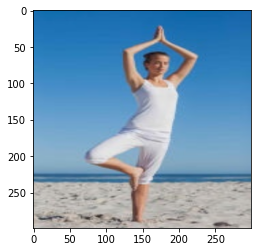

In [12]:
plt.imshow(train[0])
print(get_name(labels[0]))

In [13]:
pd.DataFrame(labels).value_counts()

5    458
1    400
3    240
2    202
0    196
4    185
dtype: int64

In [14]:
X_train, X_val, y_train, y_val = train_test_split(train , labels, test_size = 0.2,stratify=labels,shuffle=True)

X_train =X_train/255.0
X_val =X_val/255.0

In [15]:
del train
del labels

In [16]:
# Train labels
y_train=tf.keras.utils.to_categorical(y_train)

# Test labels
y_val=tf.keras.utils.to_categorical(y_val)

In [17]:
y_train.shape

(1344, 6)

Yoga


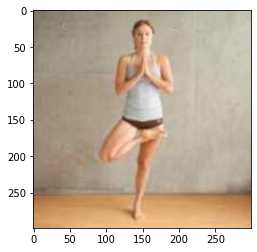

In [18]:
plt.imshow(X_train[0])
print(get_name(np.argmax(y_train[0])))

## Model [InceptionResNetV2 299x299]

In [19]:
def conv2d_batchNorm(Input,FC,kernel,stride=1,padding="same",activation="relu",bias=False):
    
    channels_axis = 3 # channel last
    x = tf.keras.layers.Conv2D(FC,kernel,strides=stride,padding=padding,use_bias=bias)(Input)
    if bias == False:
        x = tf.keras.layers.BatchNormalization(axis=channels_axis, scale=False)(x)
    if activation != None:
        x = tf.keras.layers.Activation(activation)(x)
    return x

In [20]:
def Inception_ResNet_block(x, scale, block_type, activation="relu"):
    
    
    if block_type == "A":   
        first_branch = conv2d_batchNorm(x, 32, (1,1))
        second_branch = conv2d_batchNorm(x, 32, (1,1))
        second_branch = conv2d_batchNorm(second_branch, 32, (3,3))
        third_branch = conv2d_batchNorm(x, 32, (1,1))
        third_branch = conv2d_batchNorm(third_branch, 48, (3,3))
        third_branch = conv2d_batchNorm(third_branch, 64, (3,3))
        branches = [first_branch, second_branch, third_branch]

    elif block_type == "B":
        first_branch = conv2d_batchNorm(x, 192, (1,1))
        second_branch = conv2d_batchNorm(x, 128, (1,1))
        second_branch = conv2d_batchNorm(second_branch, 160, (1, 7))
        second_branch = conv2d_batchNorm(second_branch, 192, (7, 1))
        branches = [first_branch, second_branch]

    elif block_type == "C":
        first_branch = conv2d_batchNorm(x, 192, (1,1))
        second_branch = conv2d_batchNorm(x, 192, (1,1))
        second_branch = conv2d_batchNorm(second_branch, 224, (1, 3))
        second_branch = conv2d_batchNorm(second_branch, 256, (3, 1))
        branches = [first_branch, second_branch]
    

    channel_axis =  3 # channel last

    # Layer that concatenates a list of inputs.
    # It takes as input a list of tensors, all of the same shape except for the concatenation axis, 
    # and returns a single tensor that is the concatenation of all inputs.
    concat_branches = tf.keras.layers.Concatenate(axis=channel_axis)(branches)

    # backend.int_shape ==> Returns the shape of tensor or variable as a tuple of int or None entries.
    Y = conv2d_batchNorm(concat_branches,backend.int_shape(x)[channel_axis],1,activation=None,bias=True)

    x = tf.keras.layers.Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale
                               ,output_shape=backend.int_shape(x)[1:],arguments={"scale": scale})([x, Y])
    if activation != None:
        x = tf.keras.layers.Activation(activation)(x)
    return x


In [21]:
input_shape=(299,299,3)
pooling=max
classes=1000
channel_axis = 3
classifier_activation="softmax"

In [22]:
InputLayer = tf.keras.layers.Input(shape=input_shape)

# Stem block 
x = conv2d_batchNorm(InputLayer, 32, 3, stride=2, padding="valid")
x = conv2d_batchNorm(x, 32, 3, padding="valid")
x = conv2d_batchNorm(x, 64, 3)
x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)
x = conv2d_batchNorm(x, 80, 1, padding="valid")
x = conv2d_batchNorm(x, 192, 3, padding="valid")
x = tf.keras.layers.MaxPooling2D(3, strides=2)(x)

2022-12-26 08:37:12.060421: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 08:37:12.150203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 08:37:12.150991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-26 08:37:12.152214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [23]:
# Inception-A block
first_branch = conv2d_batchNorm(x, 96, 1)
second_branch = conv2d_batchNorm(x, 48, 1)
second_branch = conv2d_batchNorm(second_branch, 64, 5)
third_branch = conv2d_batchNorm(x, 64, 1)
third_branch = conv2d_batchNorm(third_branch, 96, 3)
third_branch = conv2d_batchNorm(third_branch, 96, 3)
branch_pool = tf.keras.layers.AveragePooling2D(3, strides=1, padding="same")(x)
branch_pool = conv2d_batchNorm(branch_pool, 64, 1)
branches = [first_branch, second_branch, third_branch, branch_pool]
channel_axis = 3
x = tf.keras.layers.Concatenate(axis=channel_axis)(branches)

In [24]:
# 10x Inception-ResNet-A block
for i in range(1, 11):
    x = Inception_ResNet_block(x, scale=0.17, block_type="A")

In [25]:
# Reduction-A block
first_branch = conv2d_batchNorm(x, 384, 3, stride=2, padding="valid")
second_branch = conv2d_batchNorm(x, 256, 1)
second_branch = conv2d_batchNorm(second_branch, 256, 3)
second_branch = conv2d_batchNorm(second_branch, 384, 3, stride=2, padding="valid")
branch_pool = tf.keras.layers.MaxPooling2D(3, strides=2, padding="valid")(x)
branches = [first_branch, second_branch, branch_pool]
x = tf.keras.layers.Concatenate(axis=channel_axis)(branches)

In [26]:
# 20x Inception-ResNet-B block
for i in range(1, 21):
    x = Inception_ResNet_block(x, scale=0.1, block_type="B")

In [27]:
# Reduction-B block
first_branch = conv2d_batchNorm(x, 256, 1)
first_branch = conv2d_batchNorm(first_branch, 384, 3, stride=2, padding="valid")
second_branch = conv2d_batchNorm(x, 256, 1)
second_branch = conv2d_batchNorm(second_branch, 288, 3, stride=2, padding="valid")
third_branch = conv2d_batchNorm(x, 256, 1)
third_branch = conv2d_batchNorm(third_branch, 288, 3)
third_branch = conv2d_batchNorm(third_branch, 320, 3, stride=2, padding="valid")
branch_pool = tf.keras.layers.MaxPooling2D(3, strides=2, padding="valid")(x)
branches = [first_branch, second_branch, third_branch, branch_pool]
x = tf.keras.layers.Concatenate(axis=channel_axis)(branches)

In [28]:
# 10x Inception-ResNet-C block
for i in range(1, 10):
    x = Inception_ResNet_block(x, scale=0.2, block_type="C")
x = Inception_ResNet_block(x, scale=1.0, activation=None, block_type="C")

In [29]:
# Final convolution block: 8 x 8 x 1536
x = conv2d_batchNorm(x, 1536, 1)

In [30]:
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(classes, activation=classifier_activation)(x)

In [31]:
# Create model.
model = tf.keras.models.Model(InputLayer, x, name="inception_resnet_v2")

In [32]:
model.load_weights(r'/kaggle/input/inceptionresnetv2-weights/weights_InceptionResNetV2.h5')

In [33]:
len(model.layers)

782

In [ ]:
# model.summary()

In [34]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [35]:
classes_ = 6
model2 = tf.keras.models.Sequential([
    
    tf.keras.layers.InputLayer((299,299,3)),
    model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(classes_)
])

In [36]:
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1000)              55873736  
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 6006      
Total params: 55,879,742
Trainable params: 55,819,198
Non-trainable params: 60,544
_________________________________________________________________


In [37]:
model2.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

## Training without Augmentation 

In [37]:
Epochs=100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model2.fit(X_train,y_train,
                    epochs=Epochs,
                    validation_data=(X_val,y_val),
                    batch_size=32,
                    verbose=1)#,callbacks=[early_stopping]

2022-12-26 00:57:46.604142: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1441859328 exceeds 10% of free system memory.
2022-12-26 00:57:48.220053: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1441859328 exceeds 10% of free system memory.
2022-12-26 00:57:49.510149: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-26 00:58:04.175301: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


42/42 [==============================] - 53s 722ms/step - loss: 1.7778 - accuracy: 0.2671 - val_loss: 1.7488 - val_accuracy: 0.3680
Epoch 2/100
42/42 [==============================] - 26s 617ms/step - loss: 1.7465 - accuracy: 0.2887 - val_loss: 1.7148 - val_accuracy: 0.3620
Epoch 3/100
42/42 [==============================] - 26s 619ms/step - loss: 1.7179 - accuracy: 0.3155 - val_loss: 1.6764 - val_accuracy: 0.3828
Epoch 4/100
42/42 [==============================] - 26s 617ms/step - loss: 1.6842 - accuracy: 0.3348 - val_loss: 1.6292 - val_accuracy: 0.4125
Epoch 5/100
42/42 [==============================] - 26s 617ms/step - loss: 1.6322 - accuracy: 0.3936 - val_loss: 1.5597 - val_accuracy: 0.4540
Epoch 6/100
42/42 [==============================] - 26s 618ms/step - loss: 1.5556 - accuracy: 0.5469 - val_loss: 1.4721 - val_accuracy: 0.6558
Epoch 7/100
42/42 [==============================] - 26s 617ms/step - loss: 1.4615 - accuracy: 0.5900 - val_loss: 1.3589 - val_accuracy: 0.7181
Epoc

In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

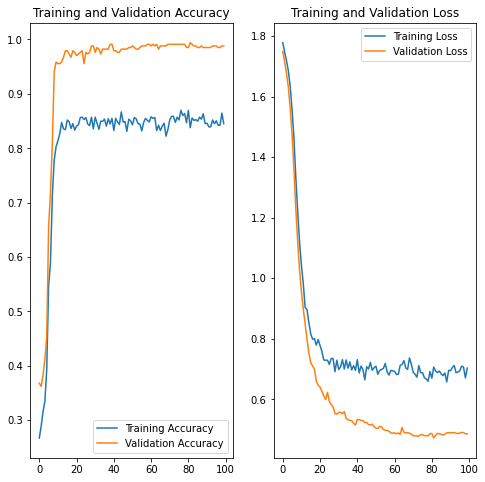

In [40]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [41]:
model2.evaluate(X_train,y_train)

2022-12-26 01:44:41.060933: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1441859328 exceeds 10% of free system memory.
2022-12-26 01:44:42.725971: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1441859328 exceeds 10% of free system memory.


42/42 [==============================] - 11s 184ms/step - loss: 0.4628 - accuracy: 0.9940


[0.462817907333374, 0.9940476417541504]

In [42]:
model2.evaluate(X_val,y_val)

11/11 [==============================] - 2s 181ms/step - loss: 0.4856 - accuracy: 0.9881


[0.48557862639427185, 0.9881305694580078]

In [43]:
del X_train
del y_train
del X_val
del y_val

## Training without Augmentation 

In [38]:
train_generator = ImageDataGenerator(    
    rotation_range=0.5,
    width_shift_range=0.2,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [40]:
Epochs=50
Batch_size=32
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
history = model2.fit(train_generator.flow(X_train,y_train,batch_size=Batch_size,seed=27,shuffle=False),
                    epochs=Epochs,
                    steps_per_epoch=X_train.shape[0] // Batch_size,
                    validation_data=(X_val,y_val),
                    verbose=1)

Epoch 1/50


2022-12-26 08:39:26.413867: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


42/42 [==============================] - 61s 1s/step - loss: 1.7808 - accuracy: 0.2418 - val_loss: 1.7645 - val_accuracy: 0.2611
Epoch 2/50
42/42 [==============================] - 38s 911ms/step - loss: 1.7536 - accuracy: 0.2723 - val_loss: 1.7378 - val_accuracy: 0.2730
Epoch 3/50
42/42 [==============================] - 38s 897ms/step - loss: 1.7376 - accuracy: 0.2723 - val_loss: 1.7208 - val_accuracy: 0.2730
Epoch 4/50
42/42 [==============================] - 38s 891ms/step - loss: 1.7245 - accuracy: 0.2723 - val_loss: 1.7028 - val_accuracy: 0.2730
Epoch 5/50
42/42 [==============================] - 38s 901ms/step - loss: 1.7070 - accuracy: 0.2738 - val_loss: 1.6731 - val_accuracy: 0.2730
Epoch 6/50
42/42 [==============================] - 37s 882ms/step - loss: 1.6799 - accuracy: 0.3237 - val_loss: 1.6260 - val_accuracy: 0.4332
Epoch 7/50
42/42 [==============================] - 37s 879ms/step - loss: 1.6287 - accuracy: 0.4100 - val_loss: 1.5538 - val_accuracy: 0.4748
Epoch 8/50
42

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

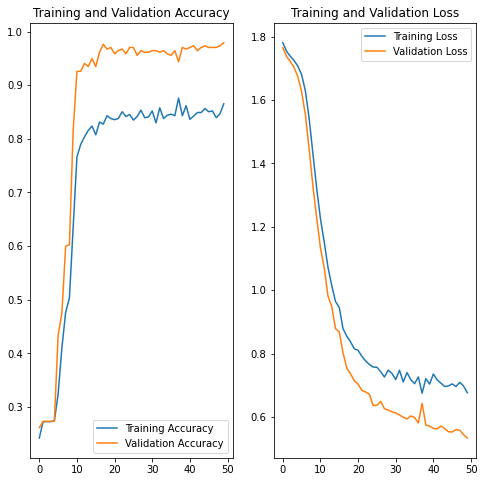

In [42]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(Epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
model2.evaluate(X_train,y_train)

2022-12-26 09:15:55.434558: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1441859328 exceeds 10% of free system memory.
2022-12-26 09:15:57.542205: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1441859328 exceeds 10% of free system memory.


42/42 [==============================] - 11s 187ms/step - loss: 0.4937 - accuracy: 0.9926


[0.49366992712020874, 0.992559552192688]

In [44]:
model2.evaluate(X_val,y_val)

11/11 [==============================] - 2s 180ms/step - loss: 0.5336 - accuracy: 0.9792


[0.5336410999298096, 0.9792284965515137]

In [45]:
del X_train
del y_train
del X_val
del y_val

In [46]:
# import os 
# os.chdir(r'/kaggle/working')
# from IPython.display import FileLink 
# FileLink(r'sports image classification using inception without Augmentation.h5')

## Saving the model

In [ ]:
saved_keras_model_filepath = '/kaggle/working/{}.h5'.format("sports image classification using inception")
model2.save(saved_keras_model_filepath)

## Load the model

In [ ]:
reloaded_keras_model=tf.keras.models.load_model('/kaggle/working/sports image classification using inception.h5')
reloaded_keras_model.summary()

## Predict our test data

In [ ]:
# reading test data
l_test=reading_resize(test_imgs,test_path,image_size)

In [45]:
test = np.array(l_test)
print(test.shape)

In [ ]:
plt.imshow(test[200])

In [46]:
test_names=[]
for g in test_imgs:   
    test_names.append(g)

In [ ]:
len(test_names)

In [47]:
#normalize
test=test/255.0

In [48]:
test_out=model2.predict(test)

2022-12-26 01:48:01.274333: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 738094656 exceeds 10% of free system memory.


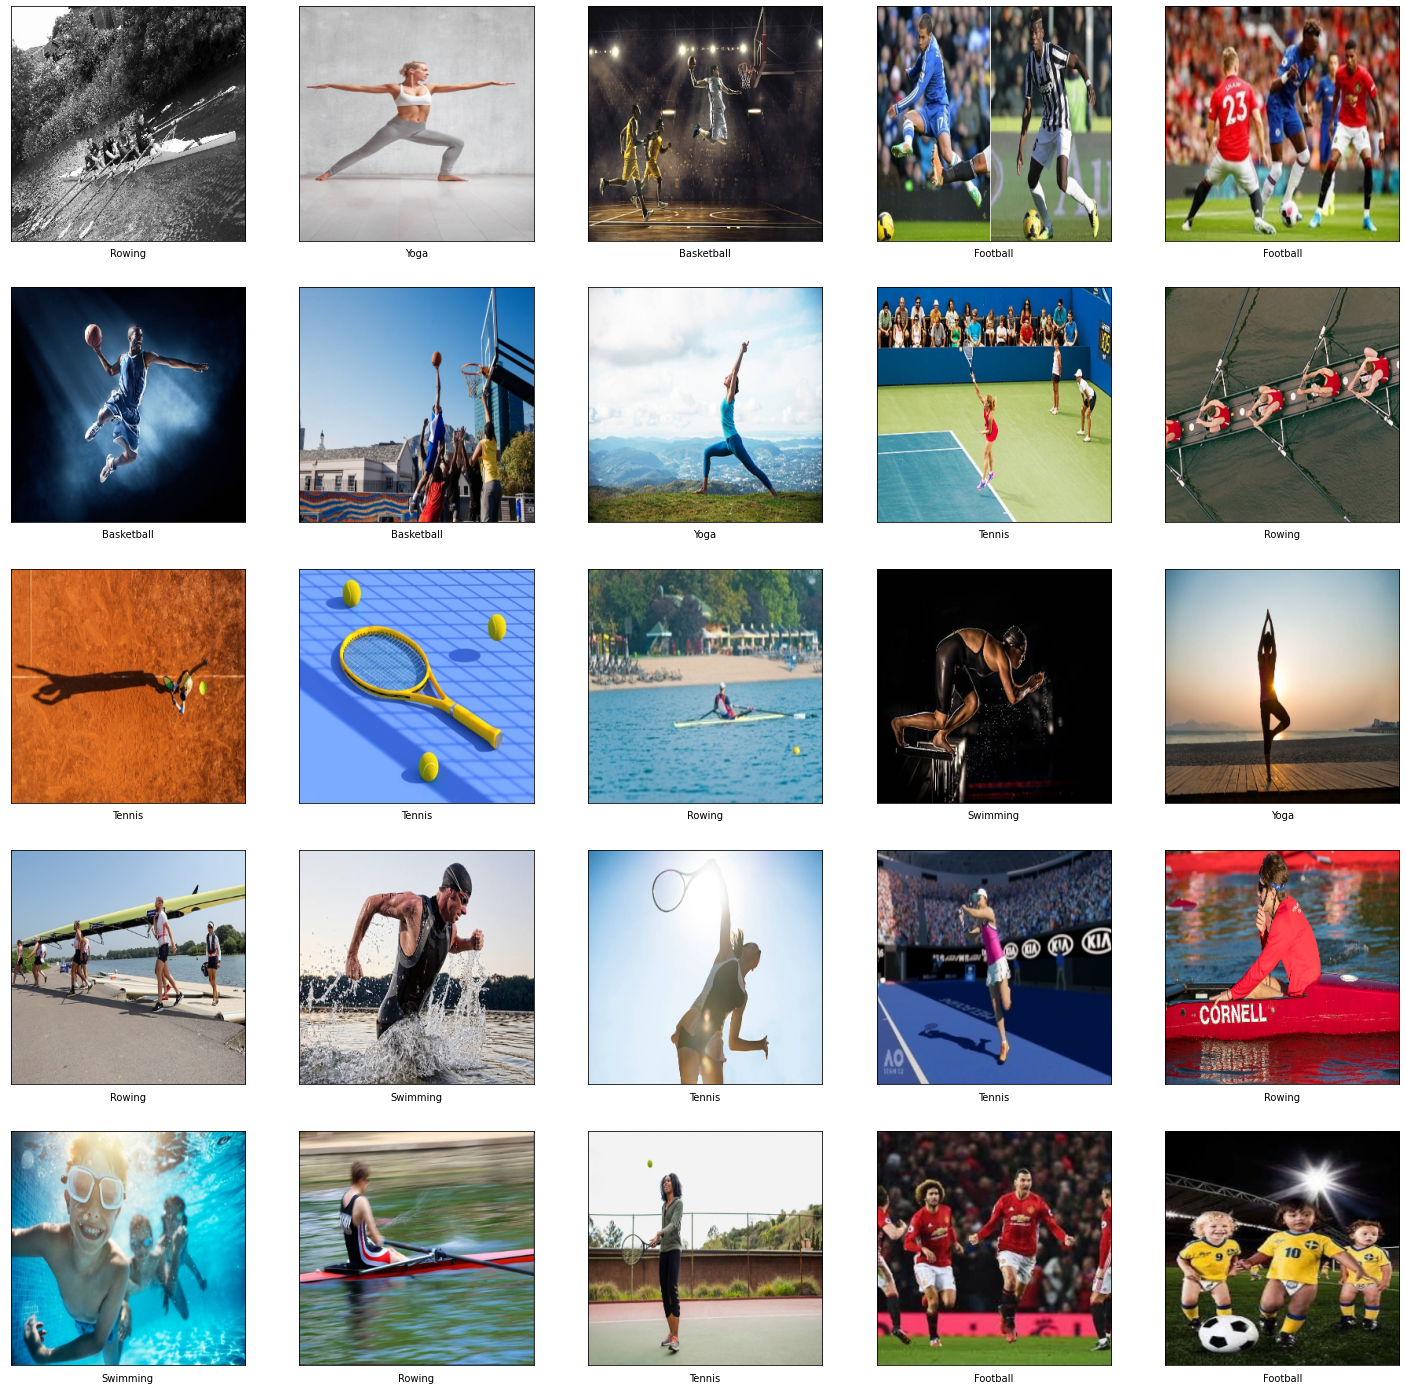

In [49]:
#pred
p=test_out

plt.figure(figsize=(25,25))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test[i])
    plt.xlabel(get_name(np.argmax(p[i])))
plt.show()

In [50]:
pred_out=[]
for i in range(len(test_out)):
    label=np.argmax(test_out[i])
    pred_out.append([test_names[i],label])

In [ ]:
# pred_out

In [51]:
Datapd=pd.DataFrame(pred_out,columns=['image_name','label'])
Datapd.head()

,image_name,label
0,623.jpg,2
1,208.jpg,5
2,473.jpg,0
3,333.jpg,1
4,537.jpg,1


In [52]:
Datapd.to_csv('/kaggle/working/sports_6_classs_preds___.csv',index=False)

In [ ]:
# saved_keras_model_filepath = '/kaggle/working/{}.h5'.format("latest ver best right model")
# model.save(saved_keras_model_filepath)